In [1]:
from src.seanmod import *

In [16]:
gpsDF = pd.read_csv("./data/googleplaystore.csv")

In [17]:
gpsDF.info()
gpsDF.shape
#We see that the rating catagory has some potential null values.
#A few of the other columns have just a few nulls. As we need rating values as our output value for regression
#we should just dump all NAs. Most losses are on useles ratings cells that can't be used anyways
gpsDF.isnull().values.sum()
#headtailcsvs("./data",n=3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


(10841, 13)

1487

In [18]:
gpsDF.dropna(axis=0,inplace=True,how="any")
print(str((10841 - gpsDF.shape[0])/10841))
#percentage loss of data from our simple NA drop.
#check consistency with info method:
gpsDF.info()
#all good!
#rekey our indicies for later:
gpsDF.reset_index(drop=True, inplace=True)


0.13661101374411955
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 13 columns):
App               9360 non-null object
Category          9360 non-null object
Rating            9360 non-null float64
Reviews           9360 non-null object
Size              9360 non-null object
Installs          9360 non-null object
Type              9360 non-null object
Price             9360 non-null object
Content Rating    9360 non-null object
Genres            9360 non-null object
Last Updated      9360 non-null object
Current Ver       9360 non-null object
Android Ver       9360 non-null object
dtypes: float64(1), object(12)
memory usage: 1023.8+ KB


In [20]:
#We have lots of numeric columns...they are trapped in string types.
#lets convert over our Reviews, Size, Installs, price
gpsDF.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Guide: Blue lines indicate max/min value. Red Lines indicate cutoff of outliers.


[1.0, 5.0]

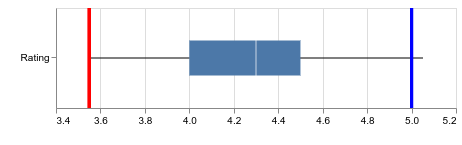

In [19]:
#Do this later!
boxplotblast(gpsDF)
[gpsDF["Rating"].min(),gpsDF["Rating"].max()]

## Converting Object Columns to Numerical Columns:

In particular, the Reviews, Size, Installs and Prices seem to be open to this. Lets first look at their range of values, to see if there are any outliers:

### Reviews Column:

False    10841
Name: Reviews, dtype: int64

In [22]:
#Lets convert to integers:
gpsDF["Reviews"] = gpsDF["Reviews"].astype("int32")    


In [26]:
gpsDF["Reviews"].dtype
[gpsDF["Reviews"].min(),gpsDF["Reviews"].max()]
gpsDF["Reviews"].isnull().count() #No NAs were introduced, we still have 9360 non-NA values

dtype('int32')

[1, 78158306]

9360

### Size Column:

So lets take a look. We immediately see that there are entries with the value "Varies with Device." We lose another 10-20% of the data if we drop. Leave this for now. 


In [32]:
(gpsDF["Size"] == "Varies with device").value_counts()

False    7723
True     1637
Name: Size, dtype: int64

### Installs:

Lets take a look. 

In [36]:
gpsDF["Installs"].sample(n=10)

1787    100,000,000+
568         100,000+
9182          1,000+
8548        100,000+
3130     10,000,000+
7431      5,000,000+
4990            100+
5099        100,000+
3647      1,000,000+
8369      1,000,000+
Name: Installs, dtype: object

In [38]:
#We have to remove commas and plus symbols. Use apply and string replace:

def installrep(x):
    hold = x.replace(",","")
    return hold.replace("+","")

gpsDF["Installs"] = gpsDF["Installs"].apply(installrep)
gpsDF["Installs"] = gpsDF["Installs"].astype("int32")


0       10000
1      500000
2     5000000
3    50000000
4      100000
Name: Installs, dtype: object

### Prices:

In [43]:
gpsDF["Price"].sample(n=50)

6042          0
6653          0
5412          0
4392          0
9200          0
4675          0
6330          0
4189    $399.99
4244      $1.99
1774          0
626           0
5046    $299.99
5482          0
606           0
4419      $4.99
8760          0
6360          0
3285          0
5795          0
70            0
1038          0
2508          0
5612          0
4086          0
4117          0
8064      $4.99
2430          0
5669          0
817           0
3689          0
3803      $1.99
3840          0
227           0
7859          0
8276          0
8375          0
5833          0
5127          0
7854          0
4410          0
8485          0
1978      $3.99
8656          0
3548          0
9173          0
2148          0
7224          0
6815          0
407           0
2676          0
Name: Price, dtype: object

In [44]:
#get rid of the dollar sign, and convert to float32.

gpsDF["Price"] = gpsDF["Price"].apply(lambda x: x.replace("$",""))
gpsDF["Price"] = gpsDF["Price"].astype("float32")
#gpsDF["Price"].sample(n=25)

    

3795      0.00000
8792      0.99000
2030      0.00000
2479      0.00000
3444      0.00000
5909      0.00000
3135      0.00000
2870      0.00000
2366      0.00000
8970      0.00000
7046      0.00000
6014      0.00000
8597      0.00000
2962      0.00000
3914      0.00000
2125      0.00000
5049    399.98999
4096      0.99000
9031      0.00000
8882      0.00000
7708      1.99000
7795      0.00000
5226      0.00000
3384      0.00000
7646      0.00000
Name: Price, dtype: float32

## Looking at Categorial Data: Category and Genre

### Category:

For our first simple regression, lets look at just the category variable. It has only 33 distinct values. This will allow for simpler one hot encoding

In [57]:
gpsDF["Category"].value_counts().shape

(33,)

In [56]:
gpsDF["Genres"].value_counts().shape #Perhaps a few too many of these. I'll Leave it for now

(115,)

## Basic Regression:

Using SKlearn, lets feed all of our integer/float numerical features into a simpleLinear Regression Model!